In [2]:
from __future__ import division
from PyDSTool import *
import dynamic_top_down_functions as df
import density_dependent_analysis as dd
import pandas as pd
from shapely import geometry
from descartes import PolygonPatch
import pandas as pd
import copy as cp
import string
import scipy.stats as stats
%pylab inline

import seaborn as sns
sns.set_style("white")

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Analysis and plots for *Dynamic parasite aggregation reduces parasite regulation of host populations and the stability of host-parasite interactions*

### Derivation of the 2-dimensional model

**Note the parameters below are defined as in Kretzschmar and Adler, 1993**

The basic model for host and parasites, after collapsing the infinite system of ODEs is:

$$\frac{dH}{dt} = (b - d)H - \alpha P $$
$$\frac{dP}{dt} = \rho P - (d + \sigma)P + \phi H - \alpha H \sum_{i=0}^{\infty}i^2 r_i$$

Where $\rho = 0$ in most macroparasite systems (parasite birth) and $\phi$ is the immigration rate follows a type II
functional response given by free-living individuals spending a very short time searching relative to the life time
of hosts and parasites. $d$ is the death rate of hosts, $\sigma$ is the death rate of parasites. $\alpha$ is the pathogenicity of the parasites which depends linearly on load. $r_i$ is the probability of a host having $i$ parasites.

The basic approach is to close this system of equations by assuming a particular probability distribution. The classic
work of Anderson and May (1978) assumed that the distribution had infinite support (NBD or Poisson). 

Start by taking the infinite series of ODEs with $\rho = 0$

$$\frac{dp_0}{dt} = -(d + \phi)p_0 + \sigma p_{1} + b \sum_{i=0}^{\infty} p_i$$

$$\frac{dp_i}{dt} = -(d + \phi + i(\alpha + \sigma))p_i + \sigma (i + 1) p_{i + 1} + \phi p_{i -1}$$

We now want to turn these into the system of two differential equations shown above. First, let's deal with $\frac{dH}{dt}$. To get this equation let's sum the the infinite series over $i$. Note that $\sum_{i=0}^{\infty} p_i = H$ and $\sum_{i=0}^{\infty} i * p_i = P$. Terms $\phi H$ and $\sigma P$ cancel out (there are both positive and negative terms). For $H$ we get

$$\frac{d \sum p_i}{dt} = -d \sum p_i - \alpha \sum i p_i + b * \sum p_i$$

which is 

$$\frac{d H}{dt} = -d H - \alpha P + \beta  H$$

Again note that terms like $\phi$ and $\sigma$ cancel out in the summation.

Now $\frac{d P}{dt}$ is just a bit trickier. The first equation $\frac{dp_0}{dt}$ doesn't matter because there are no parasites in those hosts. So we just need to multiply $\frac{dp_i}{dt}$ by $i$ and sum from $i=1$ to $\infty$.  Doing this we get

$$ \frac{d \sum i p_i}{dt} = -d \sum i p_i - \alpha \sum i^2 p_i + \sigma (\sum i (i + 1) p_{i + 1} - i^2 p_i) + \phi(\sum i p_{i -1} - i p_i)$$ 

this can be simplified to 

$$ \frac{dP}{dt} = -d P - \alpha H \sum i^2 \frac{p_i}{H} + \sigma (\sum i (i + 1) p_{i + 1} - i^2 p_i) + \phi(\sum i p_{i -1} - i p_i)$$ 

The last two nasty-looking terms with $\sigma$ and $\phi$ actually turn out to be quite simple when you take the sums. To do this just write out each term sequentially and the pattern emerges pretty quickly. You can then simplify to

$$ \frac{dP}{dt} = -d P - \sigma P + \phi H - \alpha H \sum i^2 \frac{p_i}{H}$$ 

One thing to note is that this form of the equation can also arise if you have a discrete/finite summation. For example let's say the $p_i = 0$ if $i > m$. Then you just need to sum over $m + 1$ to recover the above equations. So using a discrete distribution would work fine.

Also note that you can use a time scale argument to show that if free-living parasites life cycles are happening at a much faster time scale than the parasites within the host $\phi$ can be written as

$$ \frac{\lambda P}{H_0 + H} $$

where $\lambda$ is the rate of production of new free-living stages by the parasite.  Pugliese and Rosa (1995) also refer to it as the contact rate.


---



## Choosing a distribution

The next step is to close this distribution.  This can be done by plugging in the second moment of a chosen distribution. A common choice is a negative binomial where

$$E[X^2] = \frac{P}{H} + \left(\frac{P}{H}\right)^2 \frac{k + 1}{k}$$

You can show that using a finite negative binomial second moment gives identical predictions for regulation (see below).

### Incoporating a finite negative binomial distribution

The second moment of the finite negative binomial distribution with $k = 1$ is given by

$$
E[i^2] = \dfrac{(1 - \frac{1}{H})\frac{P}{H}(1 + \frac{P}{H})}{1 + \frac{1}{H}} + (\frac{P}{H})^2
$$

We can plug this into the equations above and do some algebra to get the equilibrium host density $H^*$

In [36]:
# Calculating the equilibrium host density under the FNBD model
# Simple matter of setting ODEs to zero and solving for the equilibrium.
# You get a quadratic from that we can calculate H*
import sympy as sp

# Define model parameters (mu=sigma is parasite death rate)
lam, H0, d, b, mu, alpha, k = sp.symbols('lam, H0, d, b, mu, alpha, k')

# Set some combination variables to make the calculations easier
holder = alpha / (b - d)
om = d + mu + (alpha / holder)

# Parameters of the quadratic
a_coef = (k*lam*holder**2 - om*k*holder**2 - alpha*k*holder**2 - alpha*holder)
b_coef = (-om*H0*k*holder + lam*holder - om*holder - alpha*H0*k*holder -
                              alpha*H0 + alpha*k*holder + alpha)
c_coef = (-om*H0 + alpha*H0*k + alpha*H0*(1 / holder))

# The two roots of the quadratic
P1 = (-b_coef + sp.sqrt(b_coef**2 - 4*a_coef*c_coef)) / (2 * a_coef)
P2 = (-b_coef - sp.sqrt(b_coef**2 - 4*a_coef*c_coef)) / (2 * a_coef)

# Compute H* can print the simplified expression
H1 = P1 * holder
H1.simplify()

-(H0*alpha**2*k + H0*alpha*k*(b + mu) - alpha**2*k - alpha*lam + alpha*(b + mu) + (b - d)*(H0*alpha - alpha + sqrt(-alpha**2*(4*H0*(b - d + k*(alpha + b - lam + mu))*(-alpha*k + d + mu) - (H0*alpha*k + H0*k*(b + mu) - alpha*k + b - lam + mu + (H0 - 1)*(b - d))**2)/(b - d)**2)))/(2*alpha*(b - d + k*(alpha + b - lam + mu)))

This looks like a mess, but divide the numerator and the denominator by $-2*\alpha$ and you can see that the denominator is a simple expression for the regulation boundary that is consistent with assuming a negative binomial distribution (e.g. Anderson and May).

### Incorporating the feasible set/partition model

To incorporate the feasible set into the model we need to make a few assumptions. First, based on simulations it is not unreasonable to assume that the feasible set can be pretty well approximated by a NBD with a varying $k$ parameter. In particular, $k$ varies with both the total number of parasites $P$ and the total number of hosts $H$.  Here is how it looks

In [4]:
# Load feasible sets from RAD analysis and flat analysis
import pandas as pd
fs_results_flat = pd.read_pickle("../results/simulated_fs_metrics.pkl")

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import scipy.interpolate as interp
from scipy.ndimage.filters import gaussian_filter

MAX = 500
MIN = 3#1

# Build arrays for interpolation
INTERP_NUM = 10000 # Number of grid points to interpolate over. # Set to 1000 for a quicker interpolation
interp_vals = np.linspace(MIN, MAX, num=INTERP_NUM)
vals = np.arange(MIN, MAX + 1)

gridx, gridy = np.meshgrid(vals, vals)
pred_gridx, pred_gridy = np.meshgrid(interp_vals, interp_vals)

xs = gridx.ravel()
ys = gridy.ravel()

# Indexing at 2 because I only want P, H >= 3
fs = fs_results_flat['k_mom_corrected'][2:, 2:] #fs_results[5]
means = fs_results_flat['mean'][2:, 2:]
vars_fs = fs_results_flat['variance'][2:, 2:]

# Set these two negative estimates to their nearest neighbors 
fs[0, 0] = 8
#fs[2, 0] = 5.7 

values = fs.ravel() # This is the moment corrected k 
#values = fs_results[8].ravel() # This is the mle k 
#values_2mom = fs_results[1].ravel() + fs_results[3].ravel()**2

In [6]:
# Interpolate on a grid
fit1 = interp.griddata(np.array([xs, ys]).T, values, 
            (pred_gridx, pred_gridy), method="cubic")

In [5]:
# Gaussian smoothing where sigma dictates the degree of smoothing
sigma = 75
data1 = gaussian_filter(fit1, sigma=sigma) # Gaussian filter to smooth out noise

In [6]:
np.max(data1)

1.9700522579117101

In [45]:
# Save the resulting interp_grid
# np.savetxt("interp_vals.txt", interp_vals)
pd.to_pickle(data1, "interp_grid_sigma{0}_flat.pkl".format(sigma))

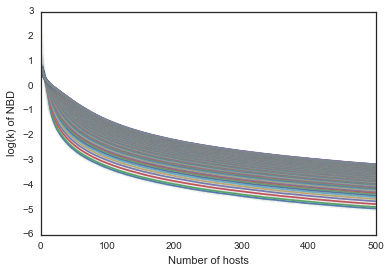

In [9]:
# Plot the interpolated data vs the raw data to compare the qualitative patterns

fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 4))
axes = [axes]

# Interpolated patterns
for i in np.arange(INTERP_NUM, step=100):
    axes[0].plot(np.linspace(MIN, MAX, num=INTERP_NUM), np.log(data1[i, :]))

# Observed patterns
for i in np.arange((MAX + 1) - MIN, step=2):
    axes[0].plot(np.arange(MIN, MAX + 1), np.log(fs[i, :]), alpha=0.1)

for ax in axes:
    ax.set_xlabel("Number of hosts")
    ax.set_ylabel("log(k) of NBD")

(0, 100)

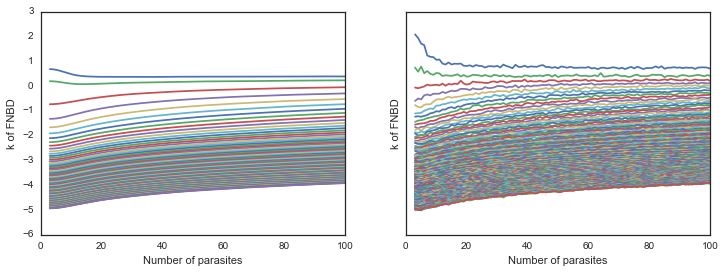

In [10]:
# Plot the interpolated data vs the raw data to compare the qualitative patterns...Hosts
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 4))
axes = axes.ravel()

# Interpolated patterns
for i in np.arange(INTERP_NUM, step=100):
    axes[0].plot(np.linspace(MIN,MAX, num=INTERP_NUM), np.log(data1[:, i]))

# Observed patterns
for i in np.arange((MAX + 1) - MIN, step=2):
    axes[1].plot(np.arange(MIN, MAX + 1), np.log(fs[:, i]))

for ax in axes:
    ax.set_xlabel("Number of parasites")
    ax.set_ylabel("k of FNBD")

axes[0].set_xlim(0, 100)

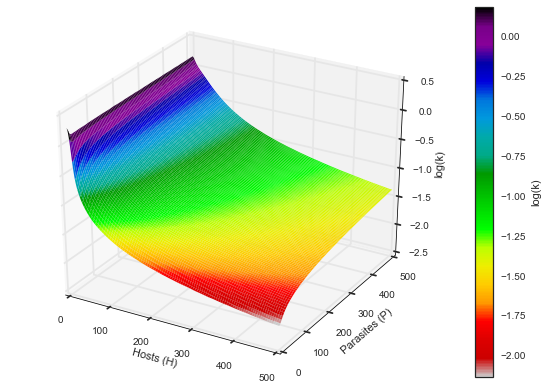

In [17]:
# NOTE: With 10,000 points this takes a long time to plot.  Use 1,000 interpolation points for a quicker plotting
# Plot the feasible surface for k

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(pred_gridx[::1], pred_gridy[::1], log10(data1[::1]), cmap=plt.cm.spectral_r, linewidth=0)

ax.set_xlabel("Hosts (H)")
ax.set_ylabel("Parasites (P)")
ax.set_zlabel("log(k)")
cb = fig.colorbar(surf)
cb.set_label("log(k)")
plt.tight_layout()
plt.savefig("../results/3d_feasible_surface.pdf")

## Question 1: How do the fixed $k$ and feasible $k$ models differ in their predictions regarding how a parasite can regulate a host population? 

In this case we are considering reuglation as the parasite preventing the host from increasing exponentially.

We can calculate the stability boundary both by simulation (which is done in `density_dependent_analysis.py`) and by a numerical stability analyis using the Routh-Hurwitz criteria.  These give similar (though not exactly the same given the various discretizations and partial derivative approximations that are made) regions for regulation.

In [ ]:
run density_dependent_analysis.py

In [11]:
# Default parameters
reload(df)
params = {'b' : 3,
                  'd' : 1.,
                  'Hk' : 500.,
                  'alpha' : 5,
                  'lam' : 20.,
                  'H0': 10,
                  'k' : 1,
                  'mu' : 0.1,
                  'xi': 0}
mus = [0.1, 2, 3]
mu_stable = []
alphas_rand = np.random.uniform(low=0, high=15, size=5000) #np.linspace(1, 10, num=100)
lambdas_rand = np.random.uniform(low=5, high=30, size=5000)

# Compute the non-simulation based stability analysis.

for mu in mus:

    params['mu'] = mu
    
    is_stable = []
    
    for i in range(len(alphas_rand)):
        
        params['lam'] = lambdas_rand[i]
        params['alpha'] = alphas_rand[i]

        is_stable.append(df.stability_analysis_feasible(params)[1])   
    
    mu_stable.append(np.array(is_stable))

/Users/mqwilber/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/mqwilber/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/mqwilber/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(msg, RuntimeWarning)


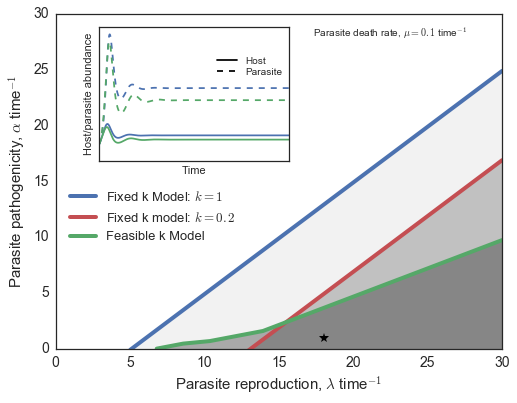

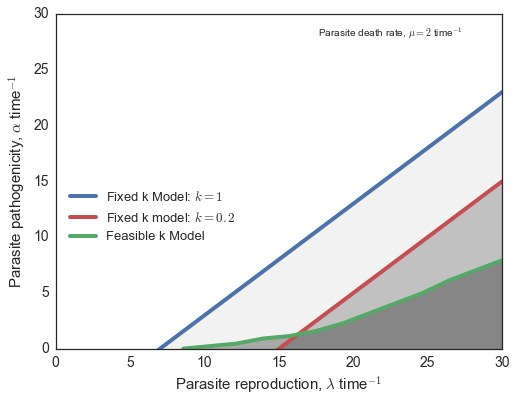

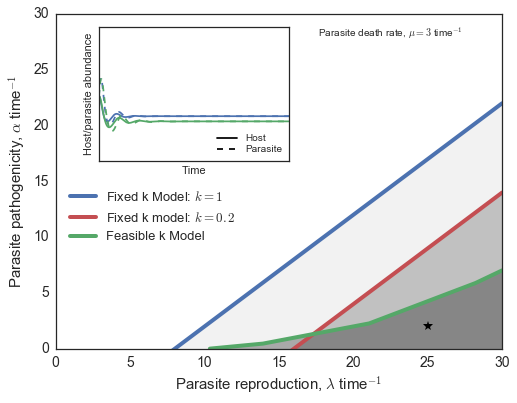

In [14]:
mus = [0.1, 2, 3]
min_cut = [1, 2, 3]

for j, mu in enumerate(mus):
    
    #if j == 0:
    #    sim_res = pd.read_pickle("../results/regulation_boundaries_mu={0}_feas_equil.pkl".format(mu))
    #else:
    sim_res = pd.read_pickle("../results/regulation_boundaries_mu={0}_feas_equil.pkl".format(mu))
    
    # Get NBD regulation boundaries
    params = {'b' : 3,
                  'd' : 1.,
                  'Hk' : 500.,
                  'alpha' : 0.5,
                  'lam' : 20.,
                  'H0': 10,
                  'k' : 0.2,
                  'mu' : mu}

    lambdas = np.linspace(4, 30, num=100)
    alphas = []
    for lam in lambdas:
        params['lam'] = lam
        alphas.append(df.nbd_boundary_alpha(params))
    
    # Simulate partition and composition model at stable equil
    params = sim_res['parameters']
    params['lam'] = 18
    params['alpha'] = 0.7
    params['k'] = 1

    dd_ode_comp = dd.build_density_dependent_ode(params, init_cond=(3, 3))
    cont_traj = dd_ode_comp.get_continuous_trajectories()
    dis_traj = dd_ode_comp.get_discrete_trajectories(delta_t=0.01, update_param=('k', "feasible_k"))
    
    # Run another simulation
    params2 = cp.copy(params)
    params2['lam'] = 25
    params2['alpha'] = 2
    params2['xi'] = 0
    
    init_cond = df.equilibrium_nbd(params2)
    dd_ode_comp2 = dd.build_density_dependent_ode(params2, init_cond=(init_cond[1] + 3, init_cond[0] + 3))
    cont_traj2 = dd_ode_comp2.get_continuous_trajectories()
    dis_traj2 = dd_ode_comp2.get_discrete_trajectories(delta_t=0.01, update_param=('k', "feasible_k"))

    # Plot the results of the regulation
    fig, ax = plt.subplots(1, 1, figsize=(8, 6), sharex=True, sharey=True)

    ax.plot(sim_res['lambda_vals'], sim_res['NBD_k_1_alphas'], lw=4, color=sns.color_palette()[0], label="Fixed k Model: $k = 1$")
    ax.fill_between(sim_res['lambda_vals'], sim_res['NBD_k_1_alphas'], facecolor="gray", alpha=0.1)

    ax.plot(lambdas, alphas, lw=4, label="Fixed k model: $k = 0.2$", color=sns.color_palette()[2])
    ax.fill_between(lambdas, alphas, facecolor="black", alpha=0.2)

    ind = np.arange(min_cut[j], len(sim_res['FEAS_w_nbd_alphas']))
    ax.plot(sim_res['lambda_vals'][ind], sim_res['FEAS_w_nbd_alphas'][ind], color=sns.color_palette()[1], lw=4, label="Feasible k Model")
    ax.fill_between(sim_res['lambda_vals'][ind], sim_res['FEAS_w_nbd_alphas'][ind], facecolor="black", alpha=0.3)

    #ax.text(0.5, 0.9, r"Parasite death rate, $\mu={0}$".format(mus[i]) + r" time$^{-1}$", size=15, ha='center', transform=ax.transAxes)
    #ax.text(0.05, 0.9, letters[i], size=18, ha="center", transform=ax.transAxes)

    #ax.text(15, 4, "Regulated", ha="center")
    ax.text(22.5, 28, r"Parasite death rate, $\mu = {0}$".format(mu) + " time$^{-1}$", ha="center")
    ax.tick_params(labelsize=14)
    ax.set_xlabel(r"Parasite reproduction, $\lambda$ time$^{-1}$", size=15)

    ax.set_ylabel(r"Parasite pathogenicity, $\alpha$ time$^{-1}$", size=15)
    ax.set_ylim(0, 30)
    ax.legend(loc=(0.02, 0.3), prop={'size': 13})
    
    # Uncomment to test against Routh-Hurwitz criteria...in general they match pretty well
    # ax.plot(lambdas_rand[mu_stable[j]], alphas_rand[mu_stable[j]], 'o', alpha=0.2)
    
    if j == 0:
        
        left, bottom, width, height = [0.2, 0.56, 0.33, 0.31]
        ax2 = fig.add_axes([left, bottom, width, height])
        ax2.tick_params(labelbottom='off', labelleft='off')

        # Plot composition model
        ax2.plot(cont_traj['t'], cont_traj['H'], color=sns.color_palette()[0])
        ax2.plot(cont_traj['t'], cont_traj['P'], '--', color=sns.color_palette()[0])

        # Plot partition model
        ax2.plot(dis_traj['t'], dis_traj['H'], color=sns.color_palette()[1])
        ax2.plot(dis_traj['t'], dis_traj['P'], '--', color=sns.color_palette()[1])

        ax2.set_xlabel("Time")
        ax2.set_ylabel("Host/parasite abundance")
        ax2.set_xlim(0, 20)

        ax2.legend([plt.Line2D([1], [1], linestyle='-', color='black'), plt.Line2D([1], [1], 
                                                        linestyle='--', color='black')], 
                               ('Host', 'Parasite'), labelspacing=0.2, loc=(0.6, 0.6))
        
        ax.plot([18], [1], '*', color="black", ms=10)
    
    if j == 2:
        
        left, bottom, width, height = [0.2, 0.56, 0.33, 0.31]
        ax2 = fig.add_axes([left, bottom, width, height])
        ax2.tick_params(labelbottom='off', labelleft='off')

        # Plot composition model
        ax2.plot(cont_traj2['t'], cont_traj2['H'], color=sns.color_palette()[0])
        ax2.plot(cont_traj2['t'], cont_traj2['P'], '--', color=sns.color_palette()[0])

        # Plot partition model
        ax2.plot(dis_traj2['t'], dis_traj2['H'], color=sns.color_palette()[1])
        ax2.plot(dis_traj2['t'], dis_traj2['P'], '--', color=sns.color_palette()[1])

        ax2.set_xlabel("Time")
        ax2.set_ylabel("Host/parasite abundance")
        ax2.set_ylim(0, 20)
        ax2.set_xlim(0, 20)

        #ax2.text(0.5, 0.62, "Parasites", ha="center", transform=ax2.transAxes)
        #ax2.text(0.5, 0.24, "Hosts", ha="center", transform=ax2.transAxes)
        ax.plot(params2['lam'], params2['alpha'], '*', color="black", ms=10)
        ax2.legend([plt.Line2D([1], [1], linestyle='-', color='black'), plt.Line2D([1], [1], 
                                                        linestyle='--', color='black')], 
                               ('Host', 'Parasite'), labelspacing=0.2, loc=(0.6, 0.02))
        

#axes[0].plot(lambdas, alphas)
#plt.tight_layout()
    #fig.savefig("../results/regulation_boundaries_mu={0}.pdf".format(mu), bbox_inches="tight")

## Fecundity stability analysis

For this portion of the analysis we are going to look at the basic host-macroparasite model with the a multiplicative reduction on host fertility (e.g. Rosa et al. 2002).

The model is where the generating function and second moment can be replaced by the corresponding functions from the negative binomial distribution

$$\begin{gather}
    \frac{dH}{dt} = -d H - \alpha P + b H \sum_{i = 0}^{\infty} r_i (1 - \xi)^i \\
    \frac{dP}{dt} = -(d + \mu)P + \phi H - \alpha H \sum_{i=0}^{\infty}i^2 r_i
\end{gather}$$

In [15]:
# Default parameters
params = {'b' : 3,
                  'd' : 1.,
                  'Hk' : 500.,
                  'alpha' : 3,
                  'lam' : 10.,
                  'H0': 10,
                  'k' : 1,
                  'mu' : 0.1,
                  'xi' : 1}

lambdas = [15, 25] # Different values of lambda
ks = [1, 0.5] # Different values of k
num_points = 100*100

all_res_feas = []
all_res_nbd = []
all_eig_feas = []
all_eig_nbd = []
all_equil_feas = []
all_equil_nbd = []


for k in ks:
    
    for lam in lambdas:

        params['lam'] = lam

        # Randomly draw points
        alphas = np.random.uniform(low=0, high=10, size=num_points)
        xis = np.random.uniform(low=0, high=1, size=num_points)
        points = zip(alphas, xis)

        stability_feas = []
        stability_nbd = []

        eigvals_feas = []
        eigvals_nbd = []

        equil_feas = []
        equil_nbd = []

        # Loop through points
        for alpha, xi in points:

            params['alpha'] = alpha
            params['xi'] = xi

            params['k'] = 5 # Just use as an initial value
            res_feas = df.stability_analysis_feasible(params)

            # Save the parameters that are stable and the eigvals for stability as well.
            if res_feas[1]:
                stability_feas.append((alpha, xi))
                eigs_feas = np.linalg.eigvals(res_feas[-1])
                eigvals_feas.append(eigs_feas[np.where(np.abs(np.real(eigs_feas)) == np.max(np.abs(np.real(eigs_feas))))[0][0]])
                equil_feas.append(res_feas[0])
            
            # Make sure k is set for NBD analysis
            params['k'] = k
            res_nbd = df.stability_analysis_fixed(params) # Use fixed for NBD

            if res_nbd[1]:
                stability_nbd.append((alpha, xi))
                eigs_nbd = np.linalg.eigvals(res_nbd[-1])
                eigvals_nbd.append(eigs_nbd[np.where(np.abs(np.real(eigs_nbd)) == np.max(np.abs(np.real(eigs_nbd))))[0][0]])
                equil_nbd.append(res_nbd[0])

        # Saving all results from the stability analysis
        all_eig_feas.append(eigvals_feas)
        all_eig_nbd.append(eigvals_nbd)
        all_res_feas.append(stability_feas)
        all_res_nbd.append(stability_nbd)
        all_equil_feas.append(equil_feas)
        all_equil_nbd.append(equil_nbd)

/Users/mqwilber/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The number of calls to function has reached maxfev = 600.
  warnings.warn(msg, RuntimeWarning)


### Simulate the dynamics of the model under a few parameter combinations

In [16]:
# Simulate some dynamics to help understand the stability figures
params1 = {'b' : 3,
                  'd' : 1.,
                  'Hk' : 500.,
                  'alpha' : 1.5,
                  'lam' : 15.,
                  'H0': 10,
                  'k' : 1,
                  'mu' : 0.1,
                  'xi' : 1 - 0.8}

# Second set of parameters
params2 = cp.copy(params1)
params2['xi'] = 1 - 0.8 #1 - 0.15
params2['alpha'] = 0.15

# Third set of parameters
params3 = cp.copy(params1)
params3['lam'] = 25
params3['alpha'] = 3
params3['xi'] = 1 - 0.8

# Fourth set of parameters
params4 = cp.copy(params3)
params4['alpha'] = 1
params4['xi'] = 1 - 0.6

all_params1 = [params1, params2, params3, params4]
all_params2 = []

# Add variable k 
for tparams in all_params1:
    
    tparams1 = cp.copy(tparams)
    tparams1['k'] = 0.5
    all_params2.append(tparams1)

all_params = all_params1 + all_params2
fixed_k_trajs = []
feas_k_trajs = []
    
for tparams in all_params:

    P, H = np.array(df.equilibrium_feasible(tparams)) + 1
    dd_ode_fec = dd.build_density_dependent_ode(tparams, time=(0, 50), init_cond=(H, P), 
                                                    birth_rate="b*((k*H) / (xi*P + k*H))**k")

    fixed_k = dd_ode_fec.get_continuous_trajectories()
    feasible_k = dd_ode_fec.get_discrete_trajectories(delta_t=0.01, update_param=('k', 'feasible_k'))

    fixed_k_trajs.append(fixed_k)
    feas_k_trajs.append(feasible_k)

### Plot the boundaries of the fixed $k$ and feasible $k$ model analysis

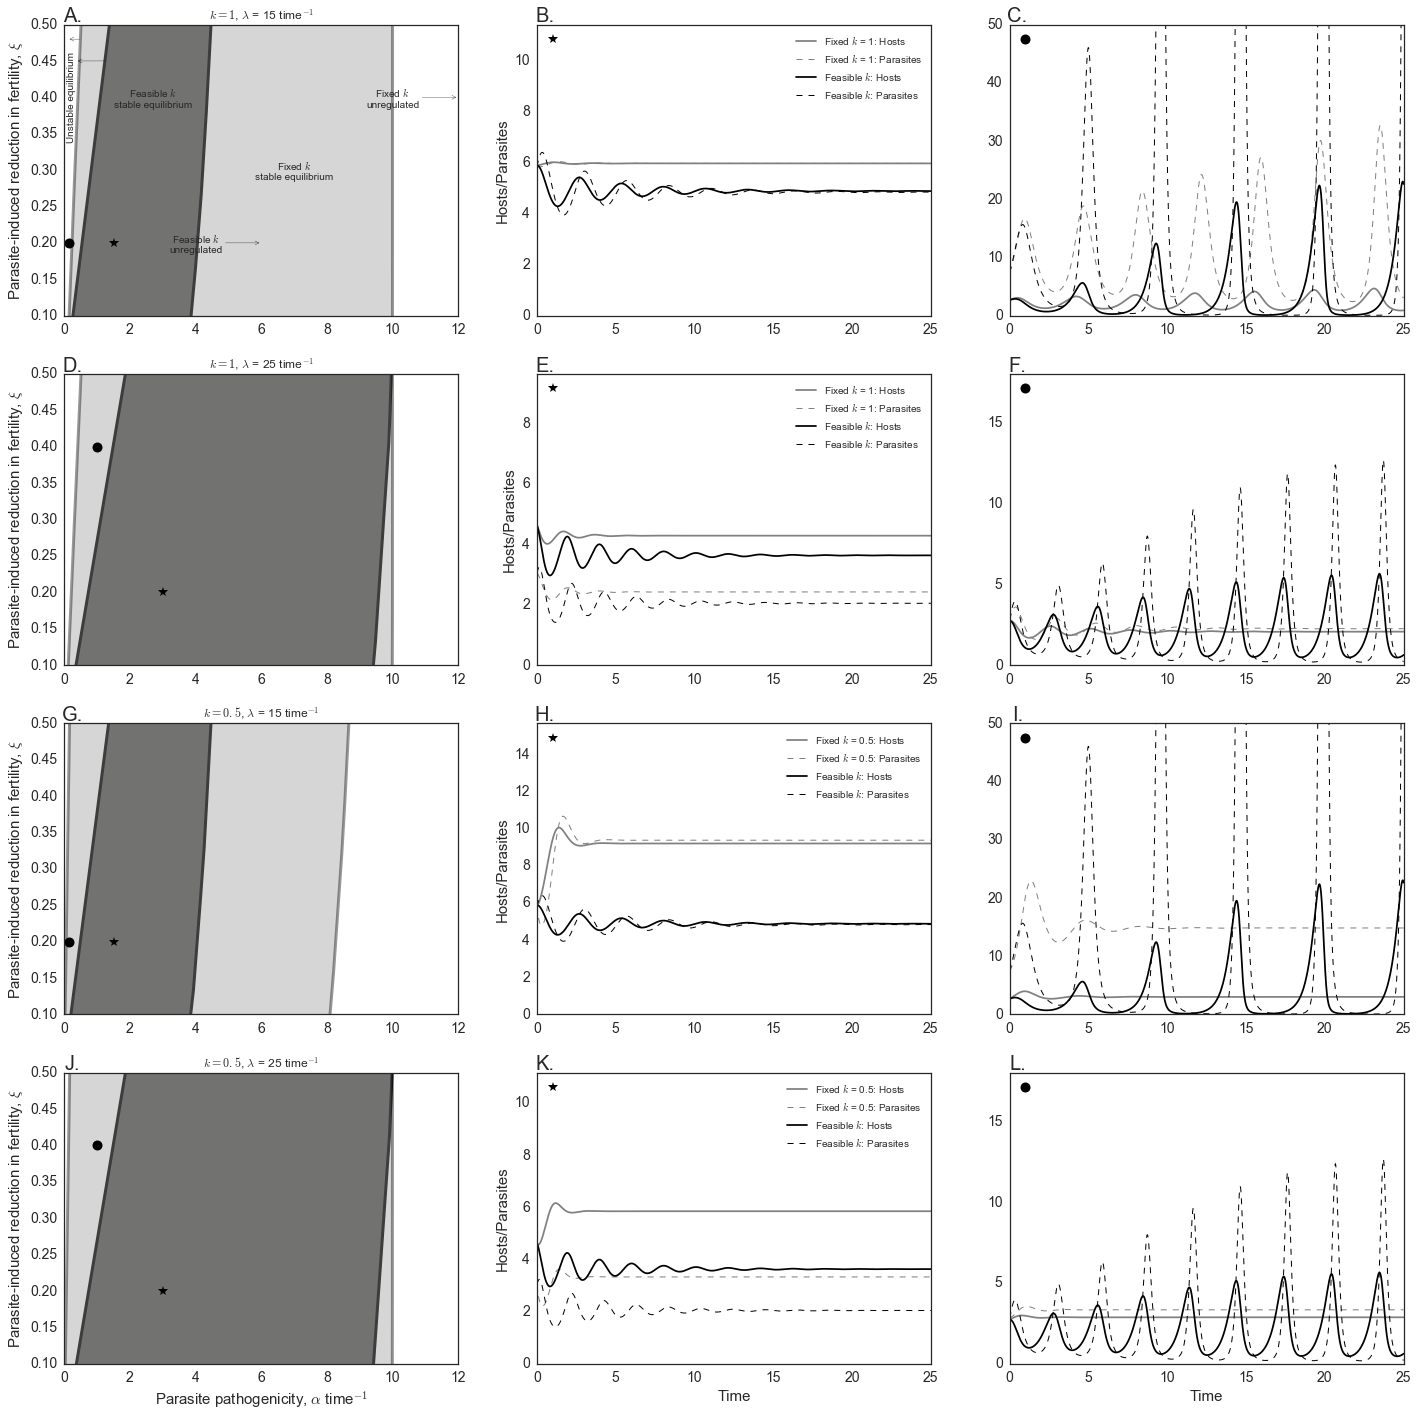

In [18]:
## Plot the simulation results 


fig, axes = plt.subplots(4, 3, figsize=(24, 24))
axes = axes.ravel()

for ax in axes:
    ax.tick_params(labelsize=14)

axes_dynamics = [axes[1], axes[2], axes[4], axes[5], axes[7], axes[8], axes[10], axes[11]]

axes_regions = [axes[0], axes[3], axes[6], axes[9]]
ks_lams = [(1, 15), (1, 25), (0.5, 15), (0.5, 25)] 

for i, ax in enumerate(axes_regions):
    
    stability_feas = all_res_feas[i]
    stability_nbd = all_res_nbd[i]
    
    ## Plot the feasible set
    alphaT_feas, xiT_feas = zip(*stability_feas)

    # Remove simulation outliers
    ind = ~np.bitwise_and(np.array(alphaT_feas) < 0.3, np.array(xiT_feas) > 0.05)

    # ax.plot(np.array(alphaT_feas)[ind], np.array(xiT_feas)[ind], 'o', alpha=0.8)
    ax.set_xlim(-0.0, 12)
    ax.set_ylim(0.1, 0.5)

    point_collection = geometry.MultiPoint(zip(np.array(alphaT_feas)[ind], np.array(xiT_feas)[ind]))
    patch = PolygonPatch(point_collection.convex_hull.buffer(0.0), fc='#595b57',
                             ec='black', fill=True, linewidth=3,
                             zorder=-1)
    ax.add_patch(patch)

    ## Plot the fixed k
    alphaT_nbd, xiT_nbd = zip(*stability_nbd)

    # Remove simulation outliers
    ind = ~np.bitwise_and(np.array(alphaT_nbd) < 0.3, np.array(xiT_nbd) > 0.05) #np.array(alphaT_nbd) > -3 #

    # ax.plot(np.array(alphaT_nbd)[ind], np.array(xiT_nbd)[ind], 'o', alpha=0.1)

    point_collection = geometry.MultiPoint(zip(np.array(alphaT_nbd)[ind], np.array(xiT_nbd)[ind]))
    patch = PolygonPatch(point_collection.convex_hull.buffer(0), fc='#999999', alpha=0.4,
                             ec='black', fill=True, linewidth=3,
                             zorder=-1)
    ax.add_patch(patch)
    
    if ax.is_last_row():
        ax.set_xlabel(r"Parasite pathogenicity, $\alpha$ time$^{-1}$", size=15)
        
    ax.set_ylabel(r"Parasite-induced reduction in fertility, $\xi$", size=15)
    ax.tick_params(labelsize=14)
    ax.set_title(r"$k = {0}$, $\lambda$ = {1}".format(*ks_lams[i]) + r' time$^{-1}$')
    
    ## Add annotations to axes
    if i == 0:
        
        ax.text(7, 0.3, "Fixed $k$\nstable equilibrium", va='center', ha="center")
        ax.annotate('Fixed $k$\nunregulated',
                     ha="center", va="center",
                     xy=(12, 0.4), xytext=(10, 0.4),
                     arrowprops=dict(arrowstyle="->",  facecolor='black', shrinkA=1))
        
        ax.text(2.7, 0.4, "Feasible $k$\nstable equilibrium", ha="center", va="center", rotation=0)
        ax.annotate('Feasible $k$\nunregulated',
                     ha="center", va="center",
                     xy=(6, 0.2), xytext=(4, 0.2),
                     arrowprops=dict(arrowstyle="->",  facecolor='black', shrinkA=1))
        
        ax.text(0.23, 0.4, "Unstable equilibrium", size=10, ha="center", va="center", rotation=90)
        ax.annotate('',
                     ha="center", va="center",
                     xy=(0.35, 0.45), xytext=(1.3, 0.45),
                     arrowprops=dict(arrowstyle="->",  facecolor='black', shrinkA=1))
        ax.annotate('',
                     ha="center", va="center",
                     xy=(0.1, 0.48), xytext=(0.5, 0.48),
                     arrowprops=dict(arrowstyle="->",  facecolor='black', shrinkA=1))
    

markers = 4*['*', 'o']
plot_num = [0, 0, 3, 3, 6, 6, 9, 9]
k_vals = 4*[1] + 4*[0.5]

for j, ax in enumerate(axes_dynamics):
    
    tfixed_k = fixed_k_trajs[j]
    tfeasible_k = feas_k_trajs[j]
    
    #ax2 = ax.twinx()
    
    ax.plot(tfixed_k['t'], tfixed_k['H'], '-', color="gray", label=r"Fixed $k$ = {0}: Hosts".format(k_vals[j]))
    ax.plot(tfixed_k['t'], tfixed_k['P'], '--', lw=1, color="gray", label=r"Fixed $k$ = {0}: Parasites".format(k_vals[j]))
    
    
    #ax2.plot(tfeasible_k['t'], tfeasible_k['k'])
    ax.plot(tfeasible_k['t'], tfeasible_k['H'], '-', color="black", label="Feasible $k$: Hosts")
    ax.plot(tfeasible_k['t'], tfeasible_k['P'], '--', lw=1, color="black", label="Feasible $k$: Parasites")
    ax.set_ylim(0, np.max(np.r_[tfixed_k['H'], tfixed_k['P'], tfeasible_k['H'], tfeasible_k['P']]) + 5)
    
    if j == 1 or j == 5:
        ax.set_ylim(0, 50)
        
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.plot([0.02*xlim[1]], [0.95*ylim[1]], marker=markers[j], ms=10, color="black")
    ax.set_xlim(0, 25)
    
    if j == 0 or j == 2 or j == 4 or j == 6:
        ax.legend(loc="upper right")
        ax.set_ylabel("Hosts/Parasites", size=15)
    
    if ax.is_last_row():
        ax.set_xlabel("Time", size=15)
        
    axes[plot_num[j]].plot(all_params[j]['alpha'], all_params[j]['xi'], marker=markers[j], ms=10, color="black")

letters = string.uppercase[:12]
for i, ax in enumerate(axes):
    ax.text(0.02, 1.01, letters[i] + ".", size=20,  ha="center", transform=ax.transAxes)

plt.savefig("../results/fecundity_stability_analysis.pdf", bbox_inches='tight')

## Plot the equilibrium results under different parameter combinations

In [25]:
alphas_all = [np.linspace(0.5, 3.8, num=50), np.linspace(0.5, 2.5, num=30)]
lambdas_all = [[16, 20], [13.5, 20]] # np.linspace(16, 30, num=20)

# alphas_all = [np.linspace(0.5, 3.8, num=50), np.linspace(0.5, 2.5, num=30)]
# lambdas_all = [[15, 30], [13.5, 20]] # np.linspace(16, 30, num=20)

params = {'b' : 3,
          'd' : 2,
          'Hk' : 500.,
          'alpha' : 1,
          'lam' : 25.,
          'H0': 10,
          'k' : 1.,
          'mu' : 0.1,
          'xi': 0}

nbd_H_all = []
feas_H_all = []
nbd_P_all = []
feas_P_all = []
nbd_k_all = []
feas_k_all = []

xis = [0, 0.7]


for m, xi in enumerate(xis):
    
    alphas = alphas_all[m]
    lambdas = lambdas_all[m]
    
    params['xi'] = xi
    
    H_vals_nbd = np.empty((len(alphas), len(lambdas)))
    H_vals_feas = np.empty((len(alphas), len(lambdas)))
    P_vals_nbd = np.empty((len(alphas), len(lambdas)))
    P_vals_feas = np.empty((len(alphas), len(lambdas)))
    k_vals_nbd = np.empty((len(alphas), len(lambdas)))
    k_vals_feas = np.empty((len(alphas), len(lambdas)))

    for i, alpha in enumerate(alphas):

        params['alpha'] = alpha

        for j, lam in enumerate(lambdas):

            params['lam'] = lam
            
            nbd_equil = df.equilibrium_nbd(params)
            H_vals_nbd[i, j] = nbd_equil[1]
            P_vals_nbd[i, j] = nbd_equil[0]
            k_vals_nbd[i, j] = params['k']
            feas_equil = df.equilibrium_feasible(params)
            H_vals_feas[i, j] = feas_equil[1]
            P_vals_feas[i, j] = feas_equil[0]
            k_vals_feas[i, j] = df.feasible_k(*feas_equil)
    
    nbd_H_all.append(H_vals_nbd)
    feas_H_all.append(H_vals_feas)
    nbd_P_all.append(P_vals_nbd)
    feas_P_all.append(P_vals_feas)
    nbd_k_all.append(k_vals_nbd)
    feas_k_all.append(k_vals_feas)

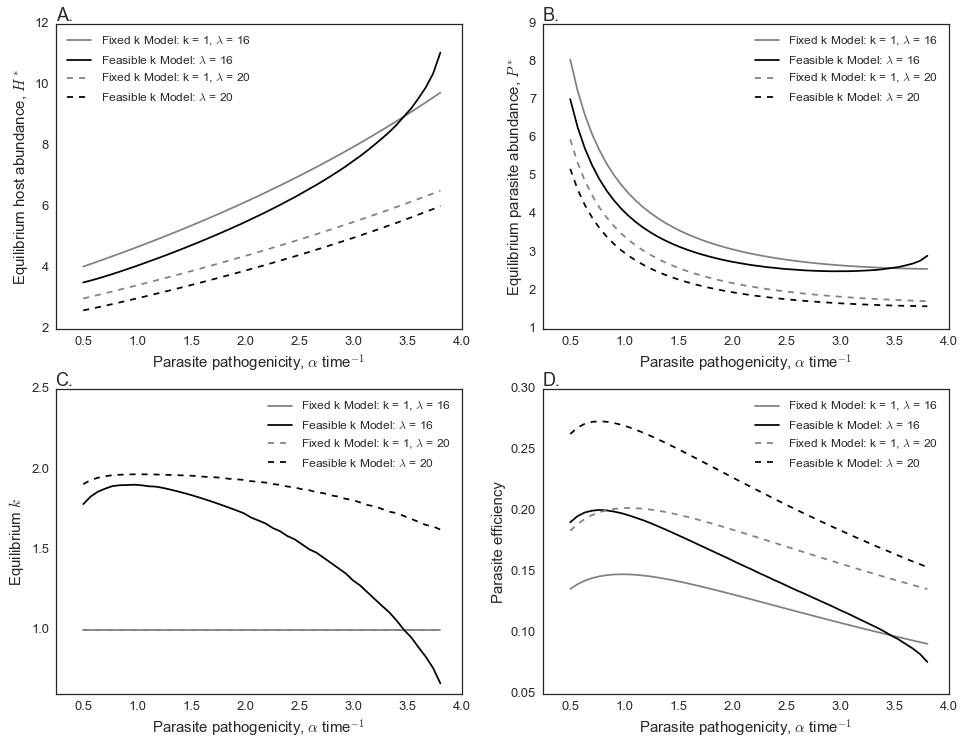

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=False)
axes = axes.ravel()

colors = sns.color_palette()[:3]
locy = [0.5, 0.3]
locx = [0.5, 0.5]

letters = ["A.", "B.", "C.", "D."]

# Just using the first set of all of the parameters
alphas = alphas_all[0]
lambdas = lambdas_all[0]
H_vals_nbd = nbd_H_all[0]
H_vals_feas = feas_H_all[0]
P_vals_nbd = nbd_P_all[0]
P_vals_feas = feas_P_all[0]
k_vals_feas = feas_k_all[0]
k_vals_nbd = nbd_k_all[0]

all_handles = []

for j in range(len(lambdas)):

    if(j == 0):
        ls = '-'
    else:
        ls = '--'

    axes[0].plot(alphas, H_vals_nbd[:,j], color="gray", ls=ls, label=r"Fixed k Model: k = 1, $\lambda$ = {0}".format(lambdas[j]))
    axes[0].plot(alphas, H_vals_feas[:,j], color="black", ls=ls, label="Feasible k Model: $\lambda$ = {0}".format(lambdas[j]))
    axes[1].plot(alphas, P_vals_nbd[:,j], color="gray", ls=ls, label="Fixed k Model: k = 1, $\lambda$ = {0}".format(lambdas[j]))
    axes[1].plot(alphas, P_vals_feas[:,j], color="black", ls=ls, label="Feasible k Model: $\lambda$ = {0}".format(lambdas[j]))
    axes[2].plot(alphas, k_vals_nbd[:,j], color="gray", ls=ls, label="Fixed k Model: k = 1, $\lambda$ = {0}".format(lambdas[j]))
    axes[2].plot(alphas, k_vals_feas[:,j], color="black", ls=ls, label="Feasible k Model: $\lambda$ = {0}".format(lambdas[j]))
    
    mu_feas =  P_vals_feas[:,j] / H_vals_feas[:,j]
    mu_nbd = P_vals_nbd[:,j] / H_vals_nbd[:,j]
    k_feas = k_vals_feas[:,j]
    k_nbd = k_vals_nbd[:,j]
    eff_feas = -1*log((1 + mu_feas / k_feas)**(-k_feas)) / P_vals_feas[:,j]
    eff_nbd = -1*log((1 + mu_nbd / k_nbd)**(-k_nbd)) / P_vals_nbd[:,j]
    
    axes[3].plot(alphas, eff_nbd, color="gray", ls=ls, label="Fixed k Model: k = 1, $\lambda$ = {0}".format(lambdas[j]))
    axes[3].plot(alphas, eff_feas, color="black", ls=ls, label="Feasible k Model: $\lambda$ = {0}".format(lambdas[j]))
    
    

    #hand2 = ax.plot(alphas_all[0], H_vals_part[:,j], color=sns.color_palette()[2], ls=ls, label="Feasible model exact")

#     if j == 0:
#         all_handles.append([hand1_H[0], hand2_H[0]])
#         all_handles.append([hand1_P[0], hand2_P[0]])
#         all_handles.append([hand1_k[0], hand2_k[0]])
        

ylabs = [r"Equilibrium host abundance, $H^*$", r"Equilibrium parasite abundance, $P^*$", r"Equilibrium $k$", r'Parasite efficiency']
ylims = [(2, 12), (1, 9), (0.6, 2.5)]
locs = ["upper left", "upper right", "upper right", "upper right"]

for i, ax in enumerate(axes.ravel()):
    
    ax.legend(loc=locs[i], prop={'size':12})
    

    ax.set_xlim(0.25, 4)
    if i < 3:
        ax.set_ylim(ylims[i])
        
        
    ax.tick_params(labelsize=13)

    ax.set_ylabel(ylabs[i], size=15)
    ax.set_xlabel(r"Parasite pathogenicity, $\alpha$ time$^{-1}$", size=15)

    #axes[0].text(0.5, 0.27, r"$\lambda = {0}$".format(lambdas[1]), size=12, ha="center", transform=ax.transAxes)
    #axes[0].text(0.5, 0.64, r"$\lambda = {0}$".format(lambdas[0]), size=12, ha="center", transform=ax.transAxes)

    ax.text(0.02, 1.01, letters[i], size=18,  ha="center", transform=ax.transAxes)

fig.savefig("../results/h_equilibrium.pdf", bbox_inches="tight")

## Plot showing that the NBD with varying $k$ is a decent approximation of the feasible set

In [23]:
import macroeco.models as md

In [24]:
# Sample from feasible set
P_H_vect = [(60, 20), (100, 15), (10, 30), (200, 20), (50, 50)]
feas_sets = []

for P, H in P_H_vect:

    feas = df.feasible_mixture([(P, H)], samples=2000, center="median")
    feas_sets.append(feas)

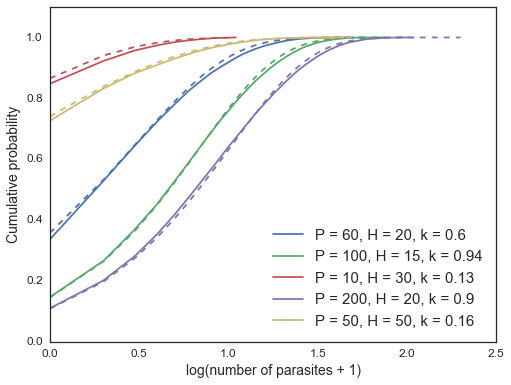

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
nbd_res = []
colors = sns.color_palette()

for i, feas in enumerate(feas_sets):
    
    # Get sampled distribution
    sampled_dist = pd.Series(feas[0].ravel()).value_counts() / len(feas[0].ravel())
    sampled_dist.sort_index(inplace=True)

    # Fit NBD to the predicted order statistics
    nbd_params = md.nbinom.fit_mle(feas[1], k_array=np.linspace(0.1, 3, num=1000))
    nbd_res.append(nbd_params)
    x = np.arange(0, P_H_vect[i][0])
    pred_dist = md.nbinom.cdf(x, *nbd_params)
    pred_rad = md.nbinom.rank(H, *nbd_params)
    
    # Plot the results
    ax.plot(np.log10(sampled_dist.index + 1), sampled_dist.cumsum().values, '-', 
                                color=colors[i], label="P = {0}, H = {1}, k = {2:.2}".format(
                                P_H_vect[i][0], P_H_vect[i][1], nbd_params[1]))
    ax.plot(np.log10(x + 1), pred_dist, '--', color=colors[i])

ax.set_xlabel("log(number of parasites + 1)", size=14)
ax.set_ylabel("Cumulative probability", size=14)
ax.tick_params(labelsize=12)
ax.set_ylim(0, 1.1)
ax.legend(loc="lower right", prop={'size': 15})
fig.savefig("../results/nbd_feas_plot.pdf")